# Films Analysis #

A set of 7000+ movies have been scraped from [Wikipedia](en.wikipedia.org) (details on this approach are listed in the **Film Scraper Demo** notebook). Our focus for this data set are starring actors of the films. The dataset contains list of names of people work on the film in a range of roles along with budget, box office and release date. The dataset also contains metadata acquired by the scraper from Wikipedia. Metadata includes the unique "slug" (the suffix of the page's URL), the page URL itself and the official poster image.

As expected the raw data originally exhibited inconsistencies due to differing page formats and the inclusion of international films. The data has been cleaned automatically (by dropping missing values and outliers) and also manually in Excel. Films with substantial amount of issues were removed, those with only slight errors were corrected. It is possible a small amount of hard to identify yet incorrect data remains.

The hope for this data is to create a classifier that can **predict the 'success' of a film by the starring actors**. The concept of what makes a film successful is a predominant factor of our analysis and is addressed in the **Reviews Analysis** notebook.

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute          import SimpleImputer
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_squared_error, accuracy_score, r2_score

from collections import Counter
from functools   import lru_cache
from random      import seed, sample
from math        import sqrt

from IPython.core.display import Image, display

# money transformations
per_million = lambda n: n / 10**6
per_billion = lambda n: n / 10**9

# tuple access
first       = lambda t: t[0]
second      = lambda t: t[1]

# seed RNG
seed(20)

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 6

In [2]:
%%html
<style>table {float:left}</style>

## The Films Dataset ##

Films released between 1970 and 2017.

In [3]:
df = pd.read_csv("../data/films-1970-2017-clean.csv", parse_dates=["released"])

print("count:", len(df))
df.head()

count: 7109


,wiki_slug,title,director_0,director_1,producer_0,producer_1,producer_2,producer_3,writer_0,writer_1,...,starring_3,starring_4,starring_5,starring_6,starring_7,released,budget,box_office,wiki_poster_url,wiki_url
0,Avatar_(2009_film),Avatar,James Cameron,NaN,James Cameron,Jon Landau,NaN,NaN,James Cameron,NaN,...,Michelle Rodriguez,Sigourney Weaver,NaN,NaN,NaN,2009-12-18,237000000.0,2.788000e+09,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Avatar_(2009_film)
1,Titanic_(1997_film),Titanic,James Cameron,NaN,James Cameron,Jon Landau,NaN,NaN,James Cameron,NaN,...,Kathy Bates,Frances Fisher,Bernard Hill,Jonathan Hyde,Danny Nucci,1997-12-19,200000000.0,2.187000e+09,https://upload.wikimedia.org/wikipedia/en/2/22...,https://en.wikipedia.org/wiki/Titanic_(1997_film)
2,Star_Wars:_The_Force_Awakens,Star Wars: The Force Awakens,J. J. Abrams,NaN,Kathleen Kennedy,J. J. Abrams,Bryan Burk,NaN,Lawrence Kasdan,J. J. Abrams,...,Adam Driver,Daisy Ridley,John Boyega,Oscar Isaac,Lupita Nyong'o,2015-12-18,306000000.0,2.068000e+09,https://upload.wikimedia.org/wikipedia/en/a/a2...,https://en.wikipedia.org/wiki/Star_Wars:_The_F...
3,Jurassic_World,Jurassic World,Colin Trevorrow,NaN,Frank Marshall,Patrick Crowley,NaN,NaN,Rick Jaffa,Amanda Silver,...,Ty Simpkins,Nick Robinson,Omar Sy,BD Wong,Irrfan Khan,2015-12-06,150000000.0,1.672000e+09,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Jurassic_World
4,The_Avengers_(2012_film),The Avengers,Joss Whedon,NaN,Kevin Feige,NaN,NaN,NaN,Joss Whedon,NaN,...,Chris Hemsworth,Scarlett Johansson,Jeremy Renner,Tom Hiddleston,Clark Gregg,2012-04-05,220000000.0,1.519000e+09,https://upload.wikimedia.org/wikipedia/en/f/f9...,https://en.wikipedia.org/wiki/The_Avengers_(20...


## Composition of the Dataset ##

The dataset holds details for a range of roles for the people behind the film, when creating the dataset, we needed we wanted to maintain the ordered list of people for each role (such as director, producers, writers and actors) This was achieved by including the role multiple times with a numbered suffixed such as **starring_0, starring_1, etc. **.

Below we can take a peek into some of the information for the film **Titanic**.

Titanic
Directed by: James Cameron
Starring: Leonardo DiCaprio, Kate Winslet, ...
Budget:     $200  million USD
Box office: $2.19 billion USD


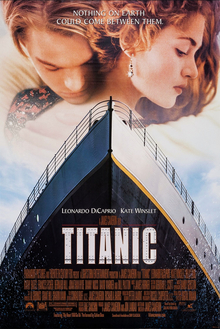

In [4]:
titanic = df.loc[df.title == "Titanic"].squeeze()

print(titanic.title)
print("Directed by:", titanic.director_0)
print("Starring: %s, %s, ..." % (titanic["starring_0"], titanic["starring_1"]))
print("Budget:     $%d  million USD" % int(titanic.budget / 10**6))
print("Box office: $%.2f billion USD" % (titanic.box_office / 10**9))

display(Image(titanic.wiki_poster_url))

As mentioned, the analysis is focused on the starring actors within the film. For simplicity we will recreate our dataset to contain only the features we will need. It may be valuable to note, the **starring_columns** list will be used frequently over the course of the analysis.

In [5]:
starring_columns = ["starring_" + str(n) for n in range(8)]

df = df[["title", "budget", "box_office", "released"] + starring_columns]
df.head()

,title,budget,box_office,released,starring_0,starring_1,starring_2,starring_3,starring_4,starring_5,starring_6,starring_7
0,Avatar,237000000.0,2.788000e+09,2009-12-18,Sam Worthington,Zoe Saldana,Stephen Lang,Michelle Rodriguez,Sigourney Weaver,NaN,NaN,NaN
1,Titanic,200000000.0,2.187000e+09,1997-12-19,Leonardo DiCaprio,Kate Winslet,Billy Zane,Kathy Bates,Frances Fisher,Bernard Hill,Jonathan Hyde,Danny Nucci
2,Star Wars: The Force Awakens,306000000.0,2.068000e+09,2015-12-18,Harrison Ford,Mark Hamill,Carrie Fisher,Adam Driver,Daisy Ridley,John Boyega,Oscar Isaac,Lupita Nyong'o
3,Jurassic World,150000000.0,1.672000e+09,2015-12-06,Chris Pratt,Bryce Dallas Howard,Vincent D'Onofrio,Ty Simpkins,Nick Robinson,Omar Sy,BD Wong,Irrfan Khan
4,The Avengers,220000000.0,1.519000e+09,2012-04-05,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Scarlett Johansson,Jeremy Renner,Tom Hiddleston,Clark Gregg


## Actors ##

To determine the predictive value of the actors in the dataset we will perform some preliminary exploration, this is heavily focused on the films of which they starred in.

### Unique Actors ###

Identify all actors within the dataset

In [6]:
def unique_actors(df):
    actors = set()

    for (_, film) in df.iterrows():
        starring = [film[col] for col in starring_columns if film[col] is not np.nan]    
        actors.update(set(starring))
        
    return sorted(actors)

all_actors = unique_actors(df)
print("Unique actors:", len(all_actors))

Unique actors: 10791


### Actor's Film History ###

To understand the predictive value of an actor we can view their film history and details of each film. We can make the conjecture that **"if an actor is starring in a higher budget film then they are more successful"**.

Create a dataset of a particular actor’s film history.

In [7]:
def actors_films(df, actor):
    indexes = [item for sublist in (df.loc[df[col] == actor].index for col in starring_columns) for item in sublist]
    actor_df = df.loc[indexes]
    actor_df.sort_values("released", inplace=True)
    actor_df.drop(columns=starring_columns, inplace=True)
    actor_df.dropna(inplace=True)
    
    return actor_df

actor = "Tom Cruise" # This variable is changable to any actor present in the films data set.
actor_df = actors_films(df, actor)

print("count:", len(actor_df))
actor_df.tail()

count: 37


,title,budget,box_office,released
300,Edge of Tomorrow,178000000.0,370000000.0,2014-06-06
106,Mission: Impossible – Rogue Nation,150000000.0,682700000.0,2015-07-31
933,Jack Reacher: Never Go Back,60000000.0,162100000.0,2016-10-21
256,The Mummy,125000000.0,409200000.0,2017-09-06
1128,American Made,50000000.0,134900000.0,2017-09-29


We can create a plot from the actor’s film history to observe the change in monetary features of the films they have starred in over time.

 We can calculate a **regression line** through our plot and observe the slope. Assuming our conjecture is valid, a positive **slope** is an indication the actor’s is starring in more significant films we can suggest this means they have become more **successful** over time.

The **root mean squared error (RMSE)** gives us an indication of how sporadic the dependant variable is in comparison to the trend suggested by our regression line. We should consider smaller RMSE values to mean our trend line can act as a more reliable predictor.

Below is a reusable plotting function of which we will see again much later in the analysis. The cell below demonstrates the trends for our particular actor. In the following plots, the y axis is per million USD.

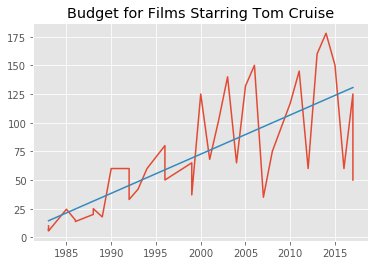

slope: +3.42
root mean squared error: 33.29


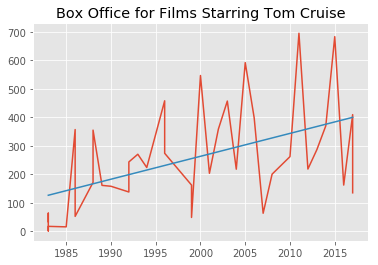

slope: +8.04
root mean squared error: 157.75


In [8]:
def root_mean_squared_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))


def plot_actor(actor_df, feature, show_mean=False, show_trend=False, transform=None):

    year = actor_df.released.dt.year
    y    = actor_df[feature]
    
    if transform:
        y = transform(y)
  
    plt.plot(year, y) # Would a scatter plot be more approriate?
    plt.title("%s for Films Starring %s" % (feature.replace("_", " ").title(), actor))
    
    if show_mean:
        mean      = np.mean(y)
        mean_line = [mean] * len(year)
        plt.plot(year, mean_line, "r--")
        
    if show_trend:
        fit    = np.polyfit(year, y, 1)
        y_pred = np.poly1d(fit)(year)
        plt.plot(year, y_pred)
    
    plt.show()
    
    if show_mean:
        print("mean: %.2f" % mean)
        
    if show_trend:
        print("slope: %+.2f" % fit[0])
        print("root mean squared error: %.2f" % root_mean_squared_error(y, y_pred))

    
plot_actor(actor_df, "budget",     show_trend=True, transform=per_million)
plot_actor(actor_df, "box_office", show_trend=True, transform=per_million)

### Actor's Metrics ###

The plots above give us an insight into an actor’s success. It may be useful if we can summarise this information into a single metric which we can use to represent the actor themselves. Potential metrics we implemented below.

The **'root squared mean' (RSM)** metric is very similar to RSME previously mentioned, the motivation is that data points that are larger will make a larger contribution to the overall mean.

The **'applied'** metrics takes the base metric and multiplies it by the amount of films in the actor’s history. The intention is to remove the inaccuracy of high means coming from actors with small film histories and effectively create a metric of **"how many high budget/box office films an actor has starred in"**.

In [9]:
def count(series):
    return len(series)

def mean(series):
    return series.mean()

def rsm(series):
    return sqrt((series **2).mean())

def applied_mean(series):
    return count(series) * mean(series)

def applied_rsm(series):
    return count(series) * rsm(series)

Previewing the metrics for the particular actor.

In [10]:
print("mean budget:     $%.2f Million (USD)" % per_million(mean(actor_df.budget)))
print("rsm budget:      $%.2f Million (USD)" % per_million(rsm(actor_df.budget)))
print()
print("mean box_office: $%.2f Million (USD)" % per_million(mean(actor_df.box_office)))
print("rsm box_office:  $%.2f Million (USD)" % per_million(rsm(actor_df.box_office)))
print()
print("applied mean box_office: $%.2f Billion (USD)" % per_billion(applied_mean(actor_df.box_office)))
print("applied rsm box_office:  $%.2f Billion (USD)" % per_billion(applied_rsm(actor_df.box_office)))

mean budget:     $69.43 Million (USD)
rsm budget:      $85.71 Million (USD)

mean box_office: $255.62 Million (USD)
rsm box_office:  $313.16 Million (USD)

applied mean box_office: $9.46 Billion (USD)
applied rsm box_office:  $11.59 Billion (USD)


As we can now summarise an actor through their metrics we can compare a sample of actors to one another. For this we will use the value of the **applied RSM of box office** for each actor. Based on the intention behind this metric, we should expect to see the highest values attributed to well-known Hollywood names that have starred in many high budget blockbusters.

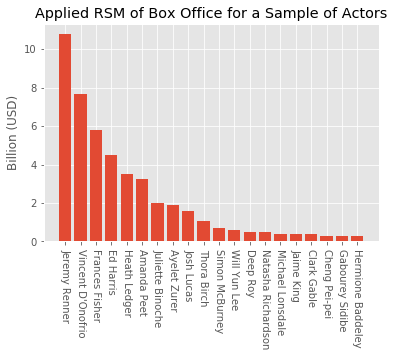

In [11]:
X = sample(all_actors, 100)
y = [applied_rsm(actors_films(df, x).box_office) for x in X] # This is expensive, consider better solution

rsm_df = pd.DataFrame(y, index=X, columns=["box_office_rsm"])
rsm_df.dropna(inplace=True)
rsm_df.sort_values(by="box_office_rsm", inplace=True, ascending=False)

top20 = rsm_df.head(20)

plt.bar(top20.index, per_billion(top20.box_office_rsm))
plt.title("Applied RSM of Box Office for a Sample of Actors")
plt.ylabel("Billion (USD)")
plt.xticks(rotation=-90)
plt.show()

## Defining Success ##

Determining what makes a film successful is a predominant factor of our analysis.

 The **Films Dataset** offers some features we can identify and derive success indicators from, we can do the same for the **Reviews Dataset**. Some of these suggested indicators referred to **’success labels’** are listed below.

Defining success is covered in much more depth in the **Reviews Analysis** notebook.

### Potential Success Labels ###

| Name          |Description  |
|:-------------:|:-----------:|
| Box Office    | **Films dataset**
| Profit        | Box Office - Budget |
| Margin        | Profit / Budget   |
| Popularity    | **Reviews dataset** |
| Vote Average  | **Reviews dataset** |
| Category      | Vote Averge\* |

\*Category is derived as discrete thresholds of Vote Averages

### Reviews Dataset ###

In [12]:
reviews_df = pd.read_csv('../data/tmdb_5000_movies.csv')[["title", "vote_average", "vote_count", "popularity"]]

print("count:", len(reviews_df))
reviews_df.head()

count: 4803


,title,vote_average,vote_count,popularity
0,Avatar,7.2,11800,150.437577
1,Pirates of the Caribbean: At World's End,6.9,4500,139.082615
2,Spectre,6.3,4466,107.376788
3,The Dark Knight Rises,7.6,9106,112.312950
4,John Carter,6.1,2124,43.926995


### Vote Average ###

As concluded in the Reviews Analysis the success label we will use for predictive modelling is the 'Vote Average'.

To continue our analysis, we take the intersection of the **Films** and **Reviews** datasets. To also improve validity, we will drop sample where the vote count does not meet the threshold of 2000. Note, our intersection is substantially smaller than our original dataset.

In [13]:
success_df = df.reset_index()

# Merging
success_df = success_df.merge(reviews_df[["title", "vote_average", "vote_count"]], left_on="title", right_on="title")
success_df.set_index("index", inplace=True) # reset index lost in merge
del success_df.index.name

# Cleaning
success_df.drop(success_df[success_df.vote_count < 2000].index, inplace=True) # decent sample size
success_df.drop_duplicates(subset=["title"], inplace=True) # remakes

print("count:", len(success_df))
success_df.head()

count: 394


,title,budget,box_office,released,starring_0,starring_1,starring_2,starring_3,starring_4,starring_5,starring_6,starring_7,vote_average,vote_count
0,Avatar,237000000.0,2.788000e+09,2009-12-18,Sam Worthington,Zoe Saldana,Stephen Lang,Michelle Rodriguez,Sigourney Weaver,NaN,NaN,NaN,7.2,11800
1,Titanic,200000000.0,2.187000e+09,1997-12-19,Leonardo DiCaprio,Kate Winslet,Billy Zane,Kathy Bates,Frances Fisher,Bernard Hill,Jonathan Hyde,Danny Nucci,7.5,7562
3,Jurassic World,150000000.0,1.672000e+09,2015-12-06,Chris Pratt,Bryce Dallas Howard,Vincent D'Onofrio,Ty Simpkins,Nick Robinson,Omar Sy,BD Wong,Irrfan Khan,6.5,8662
4,The Avengers,220000000.0,1.519000e+09,2012-04-05,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Scarlett Johansson,Jeremy Renner,Tom Hiddleston,Clark Gregg,7.4,11776
5,Furious 7,190000000.0,1.516000e+09,2015-03-04,Vin Diesel,Paul Walker,"Dwayne ""The Rock"" Johnson",Michelle Rodriguez,Tyrese Gibson,"Chris ""Ludacris"" Bridges",Jordana Brewster,Djimon Hounsou,7.3,4176


## Predicting Success ##

With an established dataset now detailing both inputs and outputs we will attempt to build a predictive model.

Details on alterate approaches we consider in order to create a predictive model are listed in the **Experimentation** section of this notebook.

### Actor's Vote Average ###

In order to create a predictive model, we are required to encode the categorical features of our dataset, in this case that is the list of actor’s names. For our encoding we can leverage the concepts used in the **Actors** section of this notebook. We will replace the occurrence of the actor’s name with a metric based on their film history. In this case, the metric we will be observing is the actor’s mean of Vote Average for the films in which they have starred in. Instead of observing a regression line in this case we will visually observe the mean (notated by the red dashed line).

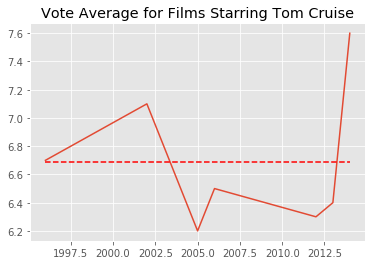

mean: 6.69


In [14]:
actor_df = actors_films(success_df, "Tom Cruise")
plot_actor(actor_df, "vote_average", show_mean=True)

### Metric Encoder ###

The following function performs the desired encoding, directly returning the encoded dataframe.

In [15]:
def encode_metric(df, feature, metric):
    
    @lru_cache(maxsize=len(all_actors))
    def lookup(actor, feature, metric):
        films = actors_films(df, actor)
        return metric(films[feature])
    
    frame = {}
    for (i, row) in df.iterrows():
        values = []
        for col in starring_columns:
            name = row[col]
            metric = lookup(name, feature, mean)
            values.append(metric)
        frame[i] = values
    
    return pd.DataFrame.from_dict(frame, orient="index", columns=starring_columns)

### Encoded Vote Data Frame ###

In [16]:
temp_df = df.loc[success_df.index]
temp_df["vote_average"] = success_df.vote_average

vote_df = encode_metric(temp_df, "vote_average", mean)
vote_df['vote_average'] = success_df.vote_average
vote_df.reset_index(inplace=True) # use index field to trace back to original dataset(s)

vote_df.head()

,index,starring_0,starring_1,starring_2,starring_3,starring_4,starring_5,starring_6,starring_7,vote_average
0,0,6.233333,7.3000,7.2000,6.875000,7.025000,NaN,NaN,NaN,7.2
1,1,7.660000,7.7000,7.5000,7.500000,7.500000,7.866667,7.500000,7.50,7.5
2,3,7.300000,6.0250,6.7000,6.500000,6.500000,6.500000,7.233333,6.95,6.5
3,4,7.112500,6.7875,7.4375,6.871429,7.211111,6.716667,6.933333,7.40,7.4
4,5,7.020000,6.8000,6.4500,6.875000,6.550000,7.200000,7.000000,7.00,7.3


We have established a dataset composed entirely of numerical values. One notable attribute of the encoding approach we have taken is that we are still able to maintain the order in which the actors were listed. This concept was a large motivation behind the original idea of the project and using encoding methods such as ‘One-Hot’ encoding did not cater for this.

### Predicting with Mean ###

We can simply attempt to predict a films Vote Average by taking the mean of our inputs for that film.

Observe both the actual and predicted vote labels along with the delta of the two in the table below.

In [17]:
X = vote_df[starring_columns]
y = vote_df.vote_average

y_pred = X.mean(axis=1)
delta  = y - y_pred
score  = r2_score(y, y_pred)

vote_df["predicted_vote"]  = y_pred
vote_df["predicted_delta"] = delta
vote_df.tail()

,index,starring_0,starring_1,starring_2,starring_3,starring_4,starring_5,starring_6,starring_7,vote_average,predicted_vote,predicted_delta
389,3239,7.450000,7.50,7.666667,8.075,8.0,8.0,8.0,NaN,8.0,7.813095,0.186905
390,3494,7.200000,8.20,8.200000,7.100,8.2,8.2,8.2,NaN,8.2,7.900000,0.300000
391,4442,6.425000,6.35,6.400000,6.100,NaN,NaN,NaN,NaN,6.1,6.318750,-0.218750
392,5034,7.833333,7.46,7.125000,7.900,NaN,NaN,NaN,NaN,7.9,7.579583,0.320417
393,5879,8.075000,7.50,8.000000,7.250,8.0,7.8,NaN,NaN,8.0,7.770833,0.229167


Viewing the distribution of deltas gives us an insight to the nature of the variance of our predicted vote.

Similarly, we can observe a considerably decent R-Squared score.

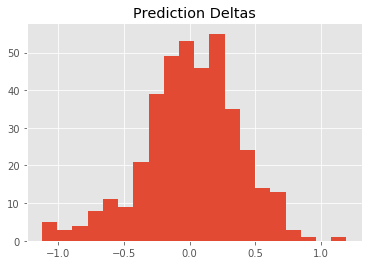

R-Squared score: 76.22%


In [18]:
plt.title("Prediction Deltas")
plt.hist(vote_df.predicted_delta, bins=20)
plt.show()

print("R-Squared score: %.2f%%" % (score * 100))

### Linear Regression ###

After a small amount of pre-processing is required to impute the NaN values in our dataset. We will fill these values with the mean of the column.

In [19]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

scores = []
for n in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)

    reg = LinearRegression().fit(X_train, y_train)
    scores.append(reg.score(X_test, y_test))

print("R-Squared score: %.2f%%" % (np.mean(scores) * 100))

R-Squared score: 79.80%


We can observe a slight improvement when instead creating a **Linear Regression Model**.

An important attribute to consider in this case is that each column represents the order of the starring actors. The coefficient for each feature factors the importance of that feature in creating the prediction and thus factors the importance of the order of which the actors were listed in.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)
reg = LinearRegression().fit(X_train, y_train)

print("Coefficients of Linear Regression Model:")
for item in zip(starring_columns, reg.coef_):
    print("%s: %+.3f" % item)

Coefficients of Linear Regression Model:
starring_0: +0.230
starring_1: +0.259
starring_2: +0.183
starring_3: +0.344
starring_4: +0.271
starring_5: +0.139
starring_6: +0.172
starring_7: -0.097


### Random Forest Regressor ###

As discovered in the **Reviews Analysis** the **Random Forest Regressor** was found to be the most accurate model for the **Reviews Data**. We will attempt to use this model to create a more accurate predictor compared to the current Linear Regression model.

In [21]:
scores = []
for n in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)

    rfr = RandomForestRegressor(n_estimators=250).fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))

print("R-Squared score: %.2f%%" % (np.mean(scores) * 100))

R-Squared score: 82.07%


We have archived a slight yet considerable improvement in the accuracy of a regressor. We use this as our final predictive model

## Dream Cast##

The **Dream Cast** feature of the web app is an interactive component of which user can select which actors they would like to see in a film. The model will return a prediction of the Vote Average for that film.

The function below allows a user to create a film in the input format the model is fit to.

In [22]:
def make_film(title, actors, limit=8):
    if not (0 < len(actors) < limit):
        raise ValueError("Must provide between 1 and %d actors." % limit)
        
    result = {"title": title}
    
    metrics = []
    for actor in actors:
        films  = actors_films(success_df, actor)
        if len(films) == 0:
            raise ValueError("Invalid actor: '%s'." % actor)
        
        metric = films.vote_average.mean()
        metrics.append(metric)
    
    metrics += [np.nan] * (limit - len(actors)) #fill remaining with na to be imputed
    metrics = imp.transform([metrics])[0]
    
    result.update(zip(starring_columns, metrics))
            
    return pd.DataFrame.from_dict(result, orient="index").T

my_film = make_film("My Film", ["Leonardo DiCaprio", "Kate Winslet", "Will Smith", "Bruce Willis"])
my_film

,title,starring_0,starring_1,starring_2,starring_3,starring_4,starring_5,starring_6,starring_7
0,My Film,7.66,7.7,6.51818,6.76667,6.90574,6.9045,6.98561,6.98939


The predictor is a **Random Forest Regressor**, this time it trained the entirety of our dataset.

In [30]:
success_predictor = RandomForestRegressor(n_estimators=250, random_state=42).fit(X, y)

def predict_success(film): # -> vote_average
    x = film[starring_columns]
    return success_predictor.predict(x)[0]

pred = predict_success(my_film)
print("Predicted vote average: %.2f" % pred)

Predicted vote average: 6.92


We can also simply categorize our film as per the **Reviews Analysis**.

In [24]:
def categorize(n):
    if   n >= 7.0: return "A"
    elif n >= 6.5: return "B"
    elif n >= 6.0: return "C"
    else:          return "D"
    
category = categorize(pred)
print("Predicted category:", category)

Predicted category: B


## Conslusion ##

We have been able to create an effective model that solely take actors as inputs and can produce what we would consider a decent success prediction. The process we took allowed to gain an understanding of how we can represent the success of an actor and through this we were able to encode our data and create a predictive model.

Overall this answers the question, **yes, we can predict success solely using actors**.

## Experimentation ##

The following section details approaches we attempted throughout the course of the project. This is not included as part of our analysis but as instead a reflective look over the not-so-successful and unsuccessful endeavours we took. This is **NOT** at all required to be read for understanding of the analysis or web app.

### "N-Hot" Encoding ###

An early approach to encode the names spread over multiple columns of the data table (starring_0 - starring_8) while maintain order was to attempt an **"N-Hot"** encoding. 

This is similar to One-Hot encoding but instead of a boolean flag, we would provide an ordinal number dependant on the position of the person in the list of that particular category. The number would be the complement of the actor’s position to the amount of actor columns in the dataset (which is 8). The speculation behind this approach was that models which apply coefficients to each feature will have that amount amplified dependant on the original ordering of the columns.

The following two examples use the demo data table.

In [25]:
demo_df = df.iloc[[0,1]]
demo_df[["title"] + starring_columns]

,title,starring_0,starring_1,starring_2,starring_3,starring_4,starring_5,starring_6,starring_7
0,Avatar,Sam Worthington,Zoe Saldana,Stephen Lang,Michelle Rodriguez,Sigourney Weaver,NaN,NaN,NaN
1,Titanic,Leonardo DiCaprio,Kate Winslet,Billy Zane,Kathy Bates,Frances Fisher,Bernard Hill,Jonathan Hyde,Danny Nucci


In [26]:
from unidecode import unidecode
from itertools import repeat

def clean_name(name):
    name = unidecode(name)
    name = name.lower()
    name = name.replace(" ", "_")
    return name

def n_hot_encode(df, limit=8):
    actors = set()

    for (_, film) in df.iterrows():
        starring = [film[sf] for sf in starring_columns if film[sf] is not np.nan]    
        actors.update(set(starring))

    actor_columns = ["starring_%s" % clean_name(actor) for actor in actors]
    film_actors = {}

    for (index, col) in df[starring_columns].iterrows():
        actor_values = dict(zip(actor_columns, repeat(0)))

        for order in range(limit):
            name = col["starring_" + str(order)]

            if name is np.nan:
                break

            inverse = limit - order
            actor_col = "starring_%s" % clean_name(name)
            actor_values[actor_col] = inverse

        film_actors[index] = actor_values
        
    return film_actors
        
        
n_hot_df = pd.DataFrame(n_hot_encode(demo_df)).T
n_hot_df.head()

,starring_bernard_hill,starring_billy_zane,starring_danny_nucci,starring_frances_fisher,starring_jonathan_hyde,starring_kate_winslet,starring_kathy_bates,starring_leonardo_dicaprio,starring_michelle_rodriguez,starring_sam_worthington,starring_sigourney_weaver,starring_stephen_lang,starring_zoe_saldana
0,0,0,0,0,0,0,0,0,5,8,4,6,7
1,3,6,1,4,2,7,5,8,0,0,0,0,0


You should notice the highest value (8) assigned to the actor which was listed first in the original data for that given film (Leonardo DiCaprio, Sam Worthington). As with One-Hot encoding a value of 0 is present if the actor was no in the film.

We did not see significant improvements to our models when using this approach as opposed to One-Hot Encoding, we decided not to use this approach.

### One Hot Encoding ###

A challenge presented to us by the nature of the dataset containing predominantly categorical variables in the form of names is having to encode the dataset before being usable to create a predictive model.

Due to our categories being spread over multiple columns we built a custom One Hot encoder, it takes a prefixed argument for taking multiple features that belong to the same category such as **starring_0** and **starring_1**.

It should be noted the similarities with the custom "N-Hot" encoder above.

In [27]:
from collections import defaultdict

def one_hot_encode(df, prefix):    
    cols = [col for col in df.columns if col.startswith(prefix)]
    sub = df[cols]
    
    all_actors = unique_actors(df)

    encoded_columns = [prefix + "_" + clean_name(value) for value in all_actors]

    index_values = {}
    for (i, row) in sub.iterrows():
        values = dict(zip(encoded_columns, repeat(0)))

        for col in range(len(cols)):
            value = row[col]

            if value is np.nan:
                break

            key = prefix + "_" + clean_name(value)
            values[key] = 1

        index_values[i] = values

    return index_values

one_hot_df = pd.DataFrame(one_hot_encode(df.iloc[[0,1]], "starring")).T
one_hot_df.head()

,starring_bernard_hill,starring_billy_zane,starring_danny_nucci,starring_frances_fisher,starring_jonathan_hyde,starring_kate_winslet,starring_kathy_bates,starring_leonardo_dicaprio,starring_michelle_rodriguez,starring_sam_worthington,starring_sigourney_weaver,starring_stephen_lang,starring_zoe_saldana
0,0,0,0,0,0,0,0,0,1,1,1,1,1
1,1,1,1,1,1,1,1,1,0,0,0,0,0


We did not see suitable success using this approach, potentially due to the shape of the data after encoding. After attempting this we then shifted our focus to what is currently detailed in our analysis.

### Trialling Models ###

#### Naive Bayes ####
When attempting the encoding above we tested using Naive Bayes classifiers.

#### KNeighbors ####

Similarly, we also attempted to use KNeighbours, with a range of number of neighbors.

In the models above, we were only able to archive a weak classifier with accuracy just over 50%.

### Budget and Box Office ###

During the exploration phase, before concluding on the success labels to use, we explored the possibility of using budget and box office. This is still present partially in our exploration of the **Actors** section of the notebook.

We expected some correlation between budget and box office of our films.

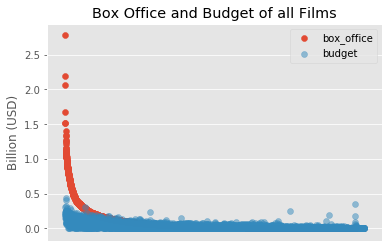

In [28]:
plt.scatter(df.index, df.box_office / 10**9)
plt.scatter(df.index, df.budget / 10**9, alpha=0.5)
plt.title("Box Office and Budget of all Films")
plt.ylabel("Billion (USD)")
plt.xticks([])
plt.legend()
plt.show()

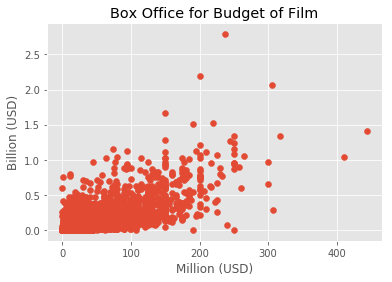

In [29]:
plt.scatter(df.budget / 10**6, df.box_office / 10**9)
plt.title("Box Office for Budget of Film")
plt.xlabel("Million (USD)")
plt.ylabel("Billion (USD)")
plt.show()

This was removed as it did not fit with our analysis but still holds noteworthy to the process of finding what was fitting.